In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [2]:
run_qs = RunStats.objects.filter(psearch__id=83, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

,K,alpha,coherence,exclusivity,max_iter,rng_seed,run_id,top_chain_var
0,20,0.01,0.400404,0.523049,50,1,2154,0.010
1,45,0.05,0.514492,0.775650,50,1,2137,0.005
2,45,0.01,0.493715,0.846099,50,1,2145,0.010
3,45,0.05,0.370210,0.701541,50,1,2122,0.100
4,45,0.10,0.506084,0.780998,50,1,2121,0.005
5,45,0.10,0.491302,0.871996,50,1,2120,0.010
6,50,0.01,0.496631,0.781455,50,1,2112,0.005
7,45,0.10,0.416262,0.824821,50,1,2119,0.050
8,45,0.01,0.508955,0.742253,50,1,2111,0.005
9,45,0.05,0.480421,0.870453,50,1,2136,0.010


In [3]:
run_id = 2155

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 3934749.14997559}


,topic__id,topic__title,totalscore
0,178515,stop words,619234.291928
1,178481,procedural 1,273809.686006
2,178498,economic policy 1,202963.147750
3,178513,procedural 2,142553.991272
4,178495,europe,141410.998528
5,178489,procedural 3,120756.670825
6,178497,general policy statements,116614.982983
7,178478,German-French coal plan,115945.235466
8,178484,budget,110642.907628
9,178472,green opposition,101886.271129


# party proportions aggregate over time

In [4]:
run_id = 2155
topics = Topic.objects.filter(run_id=run_id).order_by('score')

dft_all = pd.DataFrame()

for topic in topics:
    topic_id = topic.id
    topic_label = Topic.objects.get(id=topic_id).title
    t1_party_totals = pm.Utterance.objects.filter(
        doctopic__topic__run_id=run_id, 
        speaker__party__name__isnull=False,
        speaker__party__colour__isnull=False,
        document__parlperiod__n__isnull=False
    ).order_by().values('speaker__party__name').annotate(
        topic_score=Sum(
            Case(
                When(doctopic__topic=topic_id,
                     then=F('doctopic__score')),

                default=0,
                output_field=models.FloatField()
            )),
        total_score=Sum('doctopic__score'),
    ).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
        'topic_score', #doctopicscore
        'total_score',
        'topic_proportion',
        'speaker__party__id',
        'speaker__party__name',
        'speaker__party__colour'
    ).order_by('speaker__party__name')

    dft = pd.DataFrame.from_dict(list(t1_party_totals))
    dft.columns = ['party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
    dft['topic_id'] = topic_id
    dft['topic_label'] = topic_label

    dft_all = dft_all.append(dft, ignore_index=True)

In [33]:
dft_score = pd.DataFrame([dft_all['topic_label'], dft_all['party_name'], dft_all['doctopic_score']]).transpose()
dft_score = dft_score.pivot(index='topic_label', columns='party_name', values='doctopic_score')

dft_proportion = pd.DataFrame([dft_all['topic_label'], dft_all['party_name'], dft_all['doctopic_proportion']]).transpose()
dft_proportion = dft_proportion.pivot(index='topic_label', columns='party_name', values='doctopic_proportion')

In [40]:
topic_id = topic.id
topic_label = Topic.objects.get(id=topic_id).title
doc_scores_party = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False,
    document__parlperiod__n__isnull=False
).order_by().values('doctopic__score',
                    'doctopic__topic__title',
                    'speaker__party__name')

dft = pd.DataFrame.from_dict(doc_scores_party)
# to carry on other properties:
#dft.groupby(['doctopic__topic__id', 'speaker__party__name']).agg({'topic_score': 'sum', 'speaker__party__id': 'last'})
dft_scores_new = dft.groupby(['doctopic__topic__title', 'speaker__party__name']).sum().unstack()
dft_scores_new.columns = dft_scores_new.columns.droplevel()
dft_proportions_new = dft_scores_new / dft_scores_new.sum(0)

In [41]:
dft_proportions_new

speaker__party__name,afd,cducsu,fdp,gruene,linke,spd
doctopic__topic__title,,,,,,
Berlin,0.001077,0.014979,0.010312,0.001325,0.001690,0.012473
German-French coal plan,0.008675,0.024621,0.017103,0.001734,0.002201,0.031789
agriculture,0.001533,0.016344,0.015992,0.004154,0.001918,0.005983
budget,0.001511,0.045468,0.022148,0.004495,0.005518,0.017594
budget 2,0.018637,0.017596,0.016987,0.051774,0.033154,0.024035
budget 3,0.001547,0.009617,0.018910,0.011329,0.004829,0.010419
coal mining industry,0.000053,0.014053,0.010355,0.001000,0.001463,0.021454
diplomacy & trade,0.011893,0.011889,0.023558,0.006807,0.011151,0.012933
east germany,0.014532,0.012338,0.011197,0.015795,0.037061,0.009879


In [8]:
dft_proportion.max()

party_name
afd       0.280329
cducsu    0.157132
fdp       0.179885
gruene    0.158376
linke     0.132584
spd       0.161485
dtype: float64

In [14]:
dft_proportion.sum()

party_name
afd       0.318178
cducsu    0.168627
fdp       0.199847
gruene    0.276274
linke     0.359588
spd       0.159615
dtype: float64

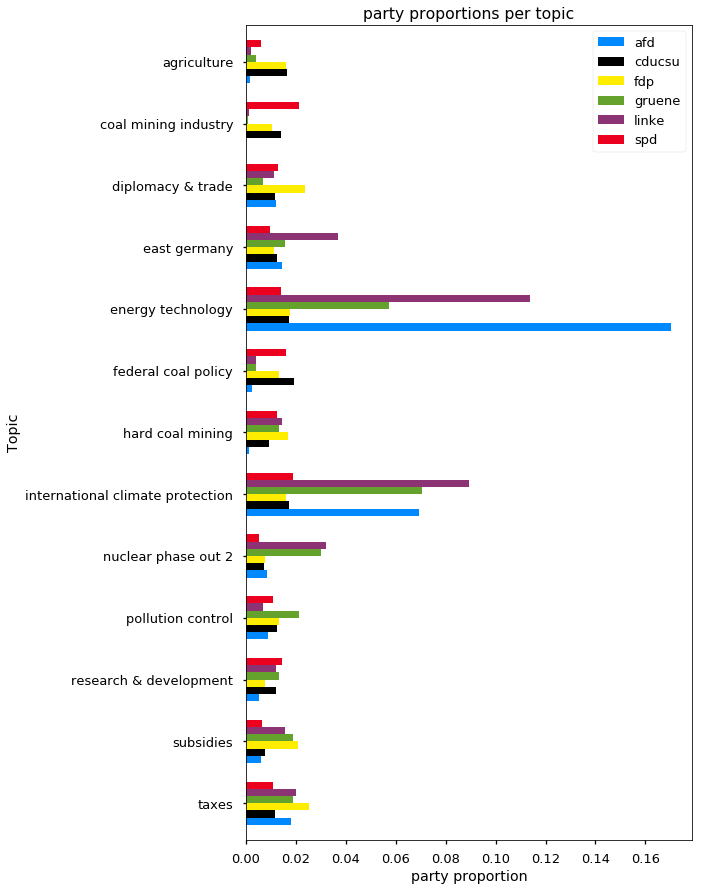

In [101]:
pct = False
stacked = False

# manual setting of colour, needs to be adjusted with new party or order change 
party_colour = ["#0088FF", "#000000", "#FFED00", "#64A12D", "#8C3473", "#EB001F"]
sns.set_palette(party_colour)
sns.set_context('talk')

topics = list(reversed(["agriculture", "coal mining industry", "diplomacy & trade",
                 "east germany", "energy technology", "federal coal policy",
                 "hard coal mining", "international climate protection", "nuclear phase out 2",
                 "pollution control", "research & development", "subsidies", "taxes"]))

dft_proportion = dft_proportions_new.loc[topics]

if pct:
    df_plot = dft_proportion.copy()
    for i in df_plot.index:
        df_plot.loc[i] = df_plot.loc[i] / df_plot.loc[i].sum() * 100
    xlabel = '% of party proportion'
    title_str = "Percentage of party proportions per topic"

else:
    xlabel = "party proportion"
    title_str = "party proportions per topic"
    df_plot = dft_proportion

ax = df_plot.plot.barh(stacked=stacked, # title=topic_names[0],
                 figsize=(8,15), width=0.7)

ax.set(xlabel=xlabel, ylabel='Topic', title=title_str)

if pct:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
else:
    plt.legend(title="")

filename = os.path.join(save_dir, "party_proportions_run_{}_selection".format(run_id))
plt.savefig(filename, dpi=300, bbox_inches="tight")

In [90]:
# the same for regions

# see also notebook topic_list_and_analysis_of_parties_and_regions

coal_regions = cmodels.Region.objects.filter(name__in=["Brandenburg", "North Rhine-Westphalia", "Saxony"])
non_coal_regions = cmodels.Region.objects.filter(name__in=["Baden-Württemberg", "Bavaria", "Berlin", "Bremen", "Hamburg", "Hesse",
                    "Mecklenburg-Vorpommern", "Lower Saxony", "Rheinland-Pfalz",
                    "Saarland", "Saxony-Anhalt", "Schleswig-Holstein", "Thuringia"])


index_to_keyword = {0: 'coal', 1: 'ncoal'}
dfs = {}

for j, regions in enumerate([coal_regions, non_coal_regions]):
    print(list(regions))

    scores_list_qs = pm.Utterance.objects.filter(
            doctopic__topic__run_id=run_id,
            speaker__seat__seat_type=2,
            speaker__seat__list__region__in=regions
        ).distinct().order_by().values('doctopic__score', 'doctopic__topic__title')
    
    scores_list = pd.DataFrame.from_dict(scores_list_qs).groupby(['doctopic__topic__title']).sum().unstack()

    scores_direct_qs = pm.Utterance.objects.filter(
            doctopic__topic__run_id=run_id,
            speaker__seat__seat_type=1,
            speaker__seat__constituency__region__in=regions
        ).distinct().order_by().values('doctopic__score', 'doctopic__topic__title')
    
    scores_direct = pd.DataFrame.from_dict(scores_direct_qs).groupby(['doctopic__topic__title']).sum().unstack()

    df = scores_list.to_frame(name='list').join(scores_direct.to_frame(name='direct'))
    df.index = df.index.droplevel()
    df['sum'] = df.sum(1)
    dfs[index_to_keyword[j]] = df
    
region_scores = pd.concat(dfs.values(), axis=1, keys=dfs.keys())
region_proportions = region_scores / region_scores.sum()

[<Region: Brandenburg>, <Region: North Rhine-Westphalia>, <Region: Saxony>]
[<Region: Baden-Württemberg>, <Region: Bavaria>, <Region: Berlin>, <Region: Bremen>, <Region: Hamburg>, <Region: Hesse>, <Region: Lower Saxony>, <Region: Mecklenburg-Vorpommern>, <Region: Rheinland-Pfalz>, <Region: Saarland>, <Region: Saxony-Anhalt>, <Region: Schleswig-Holstein>, <Region: Thuringia>]


In [94]:
rp_clean = region_proportions.loc[:, (slice(None),'sum')]
rp_clean.columns = rp_clean.columns.droplevel(1)
rp_clean

,coal,ncoal
doctopic__topic__title,,
Berlin,0.009754,0.017007
German-French coal plan,0.027956,0.029328
agriculture,0.006499,0.013672
budget,0.021263,0.030958
budget 2,0.016491,0.025090
budget 3,0.007569,0.012235
coal mining industry,0.030257,0.010510
diplomacy & trade,0.008957,0.014045
east germany,0.016564,0.010429


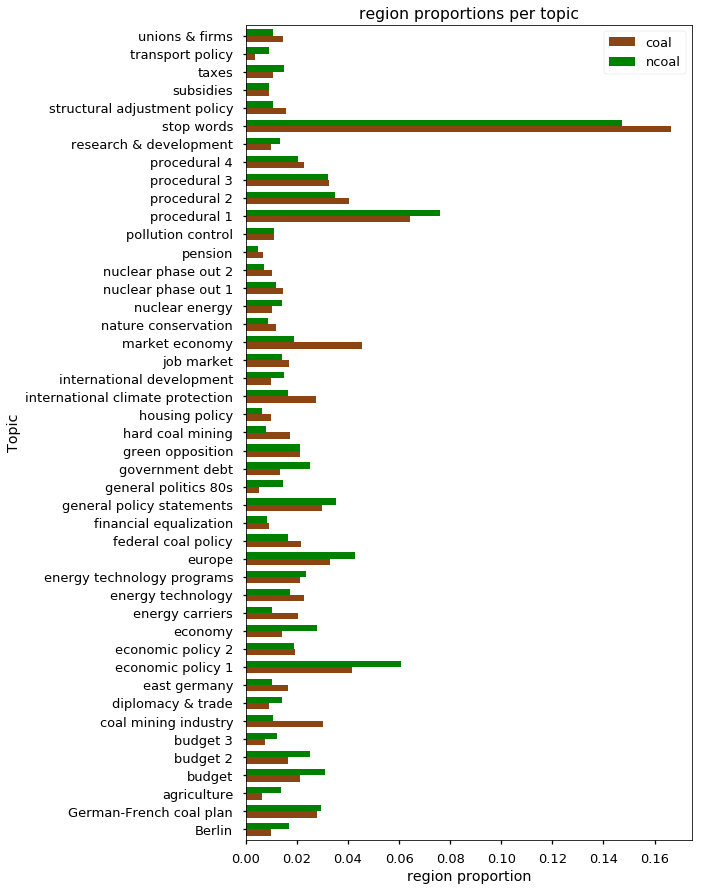

In [102]:
pct = False
stacked = False

topics = list(reversed(["agriculture", "coal mining industry", "diplomacy & trade",
                 "east germany", "energy technology", "federal coal policy",
                 "hard coal mining", "international climate protection", "nuclear phase out 2",
                 "pollution control", "research & development", "subsidies", "taxes"]))

# manual setting of colour, needs to be adjusted with new party or order change 
sns.set_palette(["saddlebrown", "green"])
sns.set_context('talk')

dft_proportion = rp_clean #.loc[topics]

if pct:
    df_plot = dft_proportion.copy()
    for i in df_plot.index:
        df_plot.loc[i] = df_plot.loc[i] / df_plot.loc[i].sum() * 100
    xlabel = '% of party proportion'
    title_str = "Percentage of party proportions per topic"

else:
    xlabel = "region proportion"
    title_str = "region proportions per topic"
    df_plot = dft_proportion

ax = df_plot.plot.barh(stacked=stacked, # title=topic_names[0],
                 figsize=(8,15), width=0.7)

ax.set(xlabel=xlabel, ylabel='Topic', title=title_str)

if pct:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
else:
    plt.legend(title="")

filename = os.path.join(save_dir, "region_proportions_run_{}_all".format(run_id))
plt.savefig(filename, dpi=300, bbox_inches="tight")

# compress folder to easily download it

In [ ]:
%%bash
zip -r plots/topic_analysis_2155.zip plots/topic_analysis_2155/